# Libraries

In [75]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from time import time
from tqdm.notebook import tqdm

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

# LeNet model

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1,6,kernel_size=5) #1 channel image input and 6 channel image as output using 5x5 kernel   
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6,16,kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(400,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1,400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        return x
        

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
apply_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])

train_set = datasets.MNIST(root='/content/gdrive/My Drive/Colab Notebooks/data', train=True, download=False, transform=apply_transform)
test_set = datasets.MNIST(root='/content/gdrive/My Drive/Colab Notebooks/data', train=False, download=False, transform=apply_transform)

# Train, Test and Plotting function

In [3]:
@torch.no_grad()
def get_num_corrects(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [87]:
def train(net, batch_size=256, lr=1e-2, n=50):
    net.train()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    train_loss_val = []
    train_acc_val = []
    for epoch in tqdm(range(n)):
        tot_loss = 0
        tot_correct = 0
        previous_epoch_timestamp = time()

        for _, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            preds = net(inputs)
            loss = F.cross_entropy(preds,labels)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            tot_loss += loss.item()
            tot_correct += get_num_corrects(preds,labels)
        train_loss_val.append(tot_loss/(_+1))
        train_acc_val.append(tot_correct/len(train_set)*100)
        if(epoch+1)>(n-6): print(f"lr:{lr} batch_size:{batch_size} epoch: {epoch+1}/{n}, train loss: {train_loss_val[epoch]:.6f}, train accuracy: {train_acc_val[epoch]:.6f}, \
    time Used: {time()-previous_epoch_timestamp:.3f}s")
    #return (train_loss_val, train_acc_val)


In [48]:
@torch.no_grad()
def test(net, batch_size=256, lr=1e-2):
    net.eval()
    tot_correct = 0
    tot_loss = 0    
    for _, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
            
        preds = net(inputs)
        loss = F.cross_entropy(preds,labels)

        tot_loss += loss 
        tot_correct += torch.sum(torch.argmax(preds,dim=1)==labels)
    print(f"lr:{lr} batch_size:{batch_size} testing accuracy: {tot_correct/len(test_set)*100:.6f}  testing loss: {tot_loss/(_+1):.6f}")
    return (tot_loss/(_+1), tot_correct/len(test_set)*100)

In [43]:
def plots(train_loss, train_accuracy, batch_size=256, lr=1e-2, n=50):
    fig = plt.figure(figsize=[15,5])
    fig.suptitle(f'Learning curves with batch_size: {batch_size}, learning_rate: {lr}', fontsize=10)
    plt.subplot(121)
    plt.plot(range(n),train_loss,'r-',label='Loss/error') 
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.grid(1)
    plt.subplot(122)
    plt.plot(range(n),train_accuracy,'g-',label='Accuracy') 
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Training Accuracy')
    plt.grid(1)

# Q5 solution

lr:0.01 batch_size:256 epoch: 45/50, train loss: 1.472206, train accuracy: 98.988333,     time Used: 5.920s
lr:0.01 batch_size:256 epoch: 46/50, train loss: 1.472129, train accuracy: 99.000000,     time Used: 5.859s
lr:0.01 batch_size:256 epoch: 47/50, train loss: 1.471893, train accuracy: 99.011667,     time Used: 5.860s
lr:0.01 batch_size:256 epoch: 48/50, train loss: 1.471339, train accuracy: 99.060000,     time Used: 5.880s
lr:0.01 batch_size:256 epoch: 49/50, train loss: 1.471061, train accuracy: 99.100000,     time Used: 5.885s
lr:0.01 batch_size:256 epoch: 50/50, train loss: 1.471708, train accuracy: 99.026667,     time Used: 5.889s

lr:0.01 batch_size:256 testing accuracy: 98.549995  testing loss: 1.476014


(tensor(1.4760, device='cuda:0'), tensor(98.5500, device='cuda:0'))

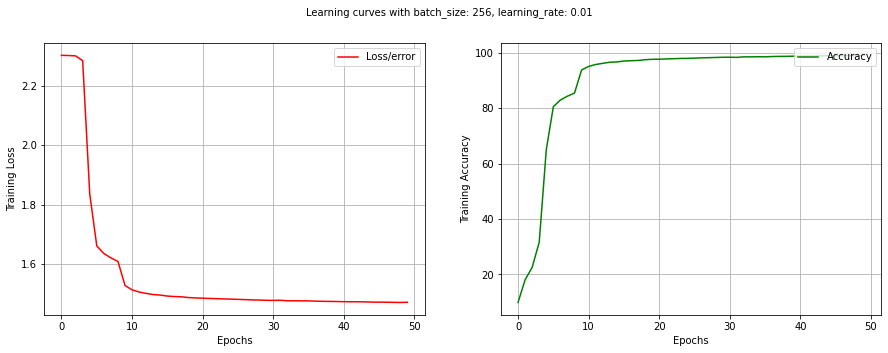

In [77]:
net1 = LeNet().to(device)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, num_workers=2)
plots(*train(net1))
test(net1)

# Q6.a solution

In [79]:
def nets_initialize():
    net1 = LeNet().to(device)
    net2 = LeNet().to(device)
    net3 = LeNet().to(device)
    net4 = LeNet().to(device)
    net5 = LeNet().to(device)
    return (net1,net2,net3,net4,net5)

In [88]:
lrs = [0.5, 0.2, 0.1, 0.05, 0.025]
Batches = [128, 256, 512, 1024]

In [82]:
nets = nets_initialize()
train_losses = []
test_losses = []

In [83]:
for i, Batch in enumerate(Batches):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=Batch, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=Batch, num_workers=4)
    train_losses.append(train(nets[i], batch_size=Batch)[0])
    test_losses.append(test(nets[i], batch_size=Batch)[0])

lr:0.01 batch_size:128 epoch: 45/50, train loss: 1.467227, train accuracy: 99.420000,     time Used: 6.577s
lr:0.01 batch_size:128 epoch: 46/50, train loss: 1.467021, train accuracy: 99.450000,     time Used: 6.601s
lr:0.01 batch_size:128 epoch: 47/50, train loss: 1.467071, train accuracy: 99.460000,     time Used: 6.627s
lr:0.01 batch_size:128 epoch: 48/50, train loss: 1.466556, train accuracy: 99.485000,     time Used: 6.704s
lr:0.01 batch_size:128 epoch: 49/50, train loss: 1.466593, train accuracy: 99.486667,     time Used: 6.719s
lr:0.01 batch_size:128 epoch: 50/50, train loss: 1.466729, train accuracy: 99.478333,     time Used: 6.652s

lr:0.01 batch_size:128 testing accuracy: 98.959999  testing loss: 1.471670


lr:0.01 batch_size:256 epoch: 45/50, train loss: 1.471683, train accuracy: 99.051667,     time Used: 5.991s
lr:0.01 batch_size:256 epoch: 46/50, train loss: 1.471644, train accuracy: 99.028333,     time Used: 6.061s
lr:0.01 batch_size:256 epoch: 47/50, train loss: 1.471870, train accuracy: 99.023333,     time Used: 6.009s
lr:0.01 batch_size:256 epoch: 48/50, train loss: 1.471416, train accuracy: 99.053333,     time Used: 6.013s
lr:0.01 batch_size:256 epoch: 49/50, train loss: 1.471953, train accuracy: 98.985000,     time Used: 5.978s
lr:0.01 batch_size:256 epoch: 50/50, train loss: 1.470933, train accuracy: 99.095000,     time Used: 5.961s

lr:0.01 batch_size:256 testing accuracy: 98.669998  testing loss: 1.474794


lr:0.01 batch_size:512 epoch: 45/50, train loss: 1.484828, train accuracy: 97.835000,     time Used: 5.743s
lr:0.01 batch_size:512 epoch: 46/50, train loss: 1.485098, train accuracy: 97.790000,     time Used: 5.732s
lr:0.01 batch_size:512 epoch: 47/50, train loss: 1.483922, train accuracy: 97.905000,     time Used: 5.692s
lr:0.01 batch_size:512 epoch: 48/50, train loss: 1.483376, train accuracy: 97.976667,     time Used: 5.726s
lr:0.01 batch_size:512 epoch: 49/50, train loss: 1.482479, train accuracy: 98.063333,     time Used: 5.697s
lr:0.01 batch_size:512 epoch: 50/50, train loss: 1.482362, train accuracy: 98.038333,     time Used: 5.749s

lr:0.01 batch_size:512 testing accuracy: 97.859993  testing loss: 1.483491


lr:0.01 batch_size:1024 epoch: 45/50, train loss: 1.611713, train accuracy: 85.331667,     time Used: 5.614s
lr:0.01 batch_size:1024 epoch: 46/50, train loss: 1.576039, train accuracy: 89.335000,     time Used: 5.597s
lr:0.01 batch_size:1024 epoch: 47/50, train loss: 1.542935, train accuracy: 92.635000,     time Used: 5.636s
lr:0.01 batch_size:1024 epoch: 48/50, train loss: 1.533781, train accuracy: 93.436667,     time Used: 5.608s
lr:0.01 batch_size:1024 epoch: 49/50, train loss: 1.528418, train accuracy: 93.861667,     time Used: 5.578s
lr:0.01 batch_size:1024 epoch: 50/50, train loss: 1.523704, train accuracy: 94.218333,     time Used: 5.561s

lr:0.01 batch_size:1024 testing accuracy: 94.889999  testing loss: 1.518066


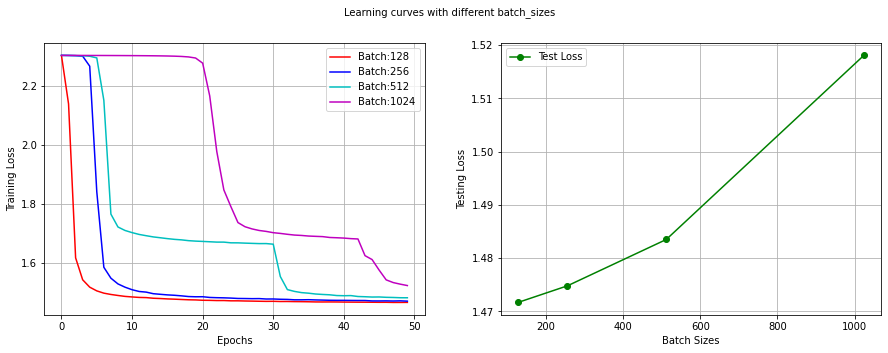

In [86]:
fig = plt.figure(figsize=[15,5])
fig.suptitle(f'Learning curves with different batch_sizes', fontsize=10)
plt.subplot(121)
plt.plot(range(50),train_losses[0],'r-',label='Batch:128') 
plt.plot(range(50),train_losses[1],'b-',label='Batch:256') 
plt.plot(range(50),train_losses[2],'c-',label='Batch:512') 
plt.plot(range(50),train_losses[3],'m-',label='Batch:1024') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.grid(1)
plt.subplot(122)
plt.plot(Batches,test_losses,'g-',label='Test Loss', marker='o') 
plt.legend(loc='upper left')
plt.xlabel('Batch Sizes')
plt.ylabel('Testing Loss')
plt.grid(1)

# Q6.b solution

In [89]:
nets = nets_initialize()
test_losses_lr = []

In [90]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, num_workers=2)
for i,lr in enumerate(lrs):
    train(nets[i], lr=lr)
    test_losses_lr.append(test(nets[i], lr=lr)[0])

lr:0.5 batch_size:256 epoch: 45/50, train loss: 2.362420, train accuracy: 9.871667,     time Used: 5.930s
lr:0.5 batch_size:256 epoch: 46/50, train loss: 2.362586, train accuracy: 9.871667,     time Used: 5.991s
lr:0.5 batch_size:256 epoch: 47/50, train loss: 2.362475, train accuracy: 9.871667,     time Used: 6.012s
lr:0.5 batch_size:256 epoch: 48/50, train loss: 2.362392, train accuracy: 9.871667,     time Used: 6.104s
lr:0.5 batch_size:256 epoch: 49/50, train loss: 2.362475, train accuracy: 9.871667,     time Used: 5.962s
lr:0.5 batch_size:256 epoch: 50/50, train loss: 2.362475, train accuracy: 9.871667,     time Used: 6.028s

lr:0.5 batch_size:256 testing accuracy: 9.800000  testing loss: 2.363983


lr:0.2 batch_size:256 epoch: 45/50, train loss: 2.348889, train accuracy: 11.236667,     time Used: 5.969s
lr:0.2 batch_size:256 epoch: 46/50, train loss: 2.348945, train accuracy: 11.236667,     time Used: 5.906s
lr:0.2 batch_size:256 epoch: 47/50, train loss: 2.348834, train accuracy: 11.236667,     time Used: 5.966s
lr:0.2 batch_size:256 epoch: 48/50, train loss: 2.348806, train accuracy: 11.236667,     time Used: 6.000s
lr:0.2 batch_size:256 epoch: 49/50, train loss: 2.348723, train accuracy: 11.236667,     time Used: 6.019s
lr:0.2 batch_size:256 epoch: 50/50, train loss: 2.348834, train accuracy: 11.236667,     time Used: 5.984s

lr:0.2 batch_size:256 testing accuracy: 11.350000  testing loss: 2.347381


lr:0.1 batch_size:256 epoch: 45/50, train loss: 1.467086, train accuracy: 99.401667,     time Used: 6.041s
lr:0.1 batch_size:256 epoch: 46/50, train loss: 1.466472, train accuracy: 99.470000,     time Used: 5.942s
lr:0.1 batch_size:256 epoch: 47/50, train loss: 1.466598, train accuracy: 99.458333,     time Used: 5.925s
lr:0.1 batch_size:256 epoch: 48/50, train loss: 1.466623, train accuracy: 99.461667,     time Used: 5.957s
lr:0.1 batch_size:256 epoch: 49/50, train loss: 1.466160, train accuracy: 99.498333,     time Used: 5.928s
lr:0.1 batch_size:256 epoch: 50/50, train loss: 1.467190, train accuracy: 99.388333,     time Used: 5.992s

lr:0.1 batch_size:256 testing accuracy: 98.959999  testing loss: 1.471484


lr:0.05 batch_size:256 epoch: 45/50, train loss: 1.464668, train accuracy: 99.661667,     time Used: 6.020s
lr:0.05 batch_size:256 epoch: 46/50, train loss: 1.464699, train accuracy: 99.653333,     time Used: 6.068s
lr:0.05 batch_size:256 epoch: 47/50, train loss: 1.464971, train accuracy: 99.640000,     time Used: 5.901s
lr:0.05 batch_size:256 epoch: 48/50, train loss: 1.464652, train accuracy: 99.656667,     time Used: 5.958s
lr:0.05 batch_size:256 epoch: 49/50, train loss: 1.464522, train accuracy: 99.678333,     time Used: 5.890s
lr:0.05 batch_size:256 epoch: 50/50, train loss: 1.464656, train accuracy: 99.650000,     time Used: 6.147s

lr:0.05 batch_size:256 testing accuracy: 98.839996  testing loss: 1.472588


lr:0.025 batch_size:256 epoch: 45/50, train loss: 1.466470, train accuracy: 99.498333,     time Used: 6.136s
lr:0.025 batch_size:256 epoch: 46/50, train loss: 1.466651, train accuracy: 99.476667,     time Used: 6.212s
lr:0.025 batch_size:256 epoch: 47/50, train loss: 1.466375, train accuracy: 99.493333,     time Used: 6.059s
lr:0.025 batch_size:256 epoch: 48/50, train loss: 1.465834, train accuracy: 99.556667,     time Used: 6.091s
lr:0.025 batch_size:256 epoch: 49/50, train loss: 1.465906, train accuracy: 99.560000,     time Used: 6.140s
lr:0.025 batch_size:256 epoch: 50/50, train loss: 1.466053, train accuracy: 99.528333,     time Used: 6.058s

lr:0.025 batch_size:256 testing accuracy: 98.909996  testing loss: 1.471910


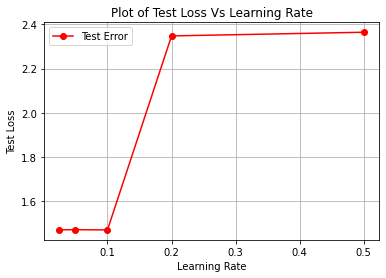

In [91]:
plt.plot(lrs,test_losses_lr, 'r-', label='Test Error', marker='o')
plt.title('Plot of Test Loss Vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.legend(loc='upper left')
plt.grid(1)
plt.show()

**I would prefer learning rate less than 0.1, as we can see a drastic change in test loss with lr > 0.1. Also for optimum test loss with respect to number of epochs: 50, I prefer 0.1 learning rate which has minimum test loss and maximum test accuracy compared to other learning rates less than 0.1 since they reach minimum (of loss function) much slower than 0.1 .**

# Q6.c solution

In [96]:
net1 = LeNet().to(device)
net1.train()
lr = 0.2
n = 50
optimizer = optim.SGD(net1.parameters(), lr=lr, momentum=0.9)
train_loss_val = []
train_acc_val = []
for epoch in tqdm(range(n)):
    tot_loss = 0
    tot_correct = 0
    previous_epoch_timestamp = time()

    if epoch%4 == 0:
      if epoch: lr *= 0.6
    optimizer = optim.SGD(net1.parameters(), lr=lr, momentum=0.9)

    for _, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        preds = net1(inputs)
        loss = F.cross_entropy(preds,labels)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        tot_loss += loss.item()
        tot_correct += get_num_corrects(preds,labels)
    train_loss_val.append(tot_loss/(_+1))
    train_acc_val.append(tot_correct/len(train_set)*100)
    if(epoch+1)>(n-6): print(f"lr:{lr} batch_size: 256 epoch: {epoch+1}/{n}, train loss: {train_loss_val[epoch]:.6f}, train accuracy: {train_acc_val[epoch]:.6f}, \
    time Used: {time()-previous_epoch_timestamp:.3f}s")

lr:0.0007255941119999997 batch_size: 256 epoch: 45/50, train loss: 1.467386, train accuracy: 99.385000,     time Used: 5.977s
lr:0.0007255941119999997 batch_size: 256 epoch: 46/50, train loss: 1.467412, train accuracy: 99.385000,     time Used: 5.962s
lr:0.0007255941119999997 batch_size: 256 epoch: 47/50, train loss: 1.467356, train accuracy: 99.385000,     time Used: 6.019s
lr:0.0007255941119999997 batch_size: 256 epoch: 48/50, train loss: 1.467382, train accuracy: 99.385000,     time Used: 5.992s
lr:0.00043535646719999985 batch_size: 256 epoch: 49/50, train loss: 1.467352, train accuracy: 99.385000,     time Used: 6.092s
lr:0.00043535646719999985 batch_size: 256 epoch: 50/50, train loss: 1.467379, train accuracy: 99.385000,     time Used: 6.073s



In [97]:
net1.eval()
tot_correct = 0
tot_loss = 0    
for _, data in enumerate(test_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
        
    preds = net1(inputs)
    loss = F.cross_entropy(preds,labels)

    tot_loss += loss 
    tot_correct += torch.sum(torch.argmax(preds,dim=1)==labels)
print(f'By using SGDR Test Loss: {tot_loss/(_+1):.6f} Test Accuracy: {tot_correct/len(test_set)}')

By using SGDR Test Loss: 1.474167 Test Accuracy: 0.986299991607666


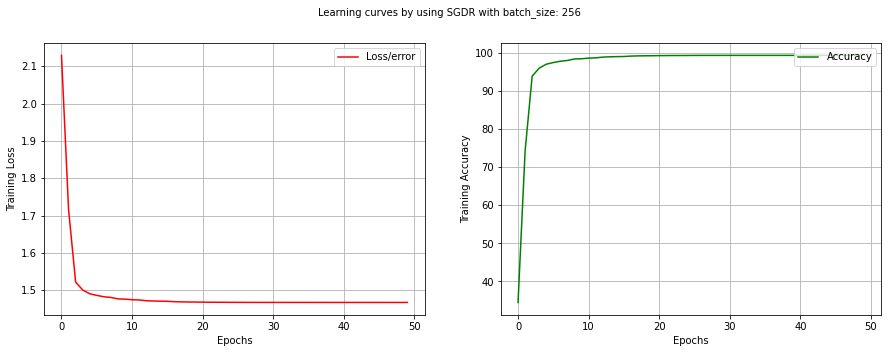

In [99]:
fig = plt.figure(figsize=[15,5])
fig.suptitle(f'Learning curves by using SGDR with batch_size: 256', fontsize=10)
plt.subplot(121)
plt.plot(range(n),train_loss_val,'r-',label='Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.grid(1)
plt.subplot(122)
plt.plot(range(n),train_acc_val,'g-',label='Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.grid(1)

**I considered the initial learning rate as 0.2 and reduced by factor 0.6 for every 4 epochs. I observed that the rate of convergence of loss function is much higher than normal training with fixed learning rate. We can also see the plots from solutions of 5 and 6.c which shows a decent picture of rate of convergence of loss functions.**

# END